# Determine what role snow plays with counter-gradient fluxes.

Confirmed snow in the log book on October 24th in the evening (confirmed by 6MDT) through at least the 26th. I am going to include the 27th in the snow covered time, as I expect patchy snow for at least that long (albeit in a limited fashion if it is warm). To make this comparison more straightforward, I will only use the preceeding 3 days before the snow. At least two other periods of snow covered ocurred during the campaign, but it is not so clear on the timing. I want to exclude potentially conflicting data classifications.

From the field book:

24/10: Anyway,  I noticed snow around 6pm MDT  
25/10: Woke up this morning with about a quarter - half inch of snow.  
27/10: A little bit of cloud cover, calm winds through out the night. Temps around 3 to 5 C. <- snow probably gone around this day, but I can't say for sure.  
28/10: Partly cloudy, calm winds through the night, < 5 m/s,. Temperatures stayed around 0c.  

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy
from scipy import stats

# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
import kgraph

# turbulence package
import turbpy
import turbpy.multiConst as mc

## Directories

In [2]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_proj, 'results')

## Plot Customization

In [3]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

In [4]:
## Read the formatted supporting snoqualmie obs
os.chdir(dir_scp)
Mtower = xr.open_dataset('SCP.Mtower_pottemps.nc')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
Mtower['obs_qh_2m'] = fluxObs.w_tc__2m_M
Mtower['obs_qh_10m'] = fluxObs.w_tc__10m_M

Mtower['time'] = pd.to_datetime(Mtower.time.values) - timedelta(hours=9)

In [5]:
# Select stable conditions only
ri = turbpy.bulkRichardson(Mtower['theta_10m'] + 273.15, Mtower['Tsfc'] + 273.15, Mtower['UBar_10m'], 10.)
Mtower['RiBulk_10m'] = (('time'), ri)
ind_10m = np.nonzero((Mtower.RiBulk_10m > 0.).values)

ri = turbpy.bulkRichardson(Mtower['theta_2m'] + 273.15, Mtower['Tsfc'] + 273.15, Mtower['UBar_2m'], 2.)
Mtower['RiBulk_2m'] = (('time'), ri)
ind_2m = np.nonzero((Mtower.RiBulk_2m > 0.).values)

In [6]:
# Snow free and snow covered date classification
sf1 = datetime(2012, 10, 21, 14, 0)
sf2 = datetime(2012, 10, 24, 14, 0)
sc1 = datetime(2012, 10, 24, 14, 1)
sc2 = datetime(2012, 10, 27, 14, 0)

sf_ind = ((pd.to_datetime(Mtower.time.values) > sf1) & (pd.to_datetime(Mtower.time.values) < sf2))
sc_ind = ((pd.to_datetime(Mtower.time.values) > sc1) & (pd.to_datetime(Mtower.time.values) < sc2))

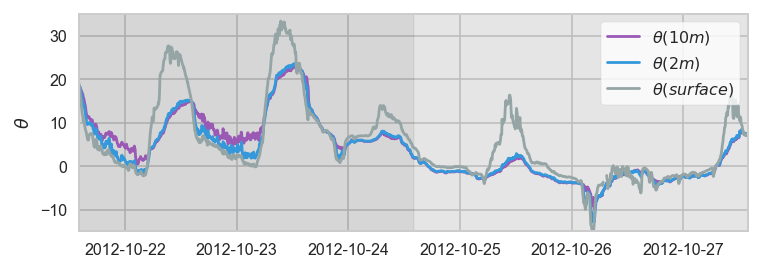

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))

ax.plot(Mtower.time, Mtower.theta_10m, label=r'$\theta(10m)$')
ax.plot(Mtower.time, Mtower.theta_2m, label=r'$\theta(2m)$')
ax.plot(Mtower.time, Mtower.Tsfc, label=r'$\theta(surface)$')

ax.fill_between(pd.to_datetime(Mtower.time.values), -15, 35, where=sf_ind, color='0.2', alpha=0.2)
ax.fill_between(pd.to_datetime(Mtower.time.values), -15, 35, where=sc_ind, color='0.5', alpha=0.2)

ax.set_xlim(sf1, sc2)
ax.set_ylim(-15, 35)
ax.set_ylabel(r'$\theta$')
ax.legend(frameon=True, loc='upper right')

Left is snow free (for sure) and right there is some snow cover.

-22.5
-15.0986063441
-6.54300898403
-11.4021787187


Text(0.5,0,'$\\theta(2m) - \\theta(sfc)$ (K)')

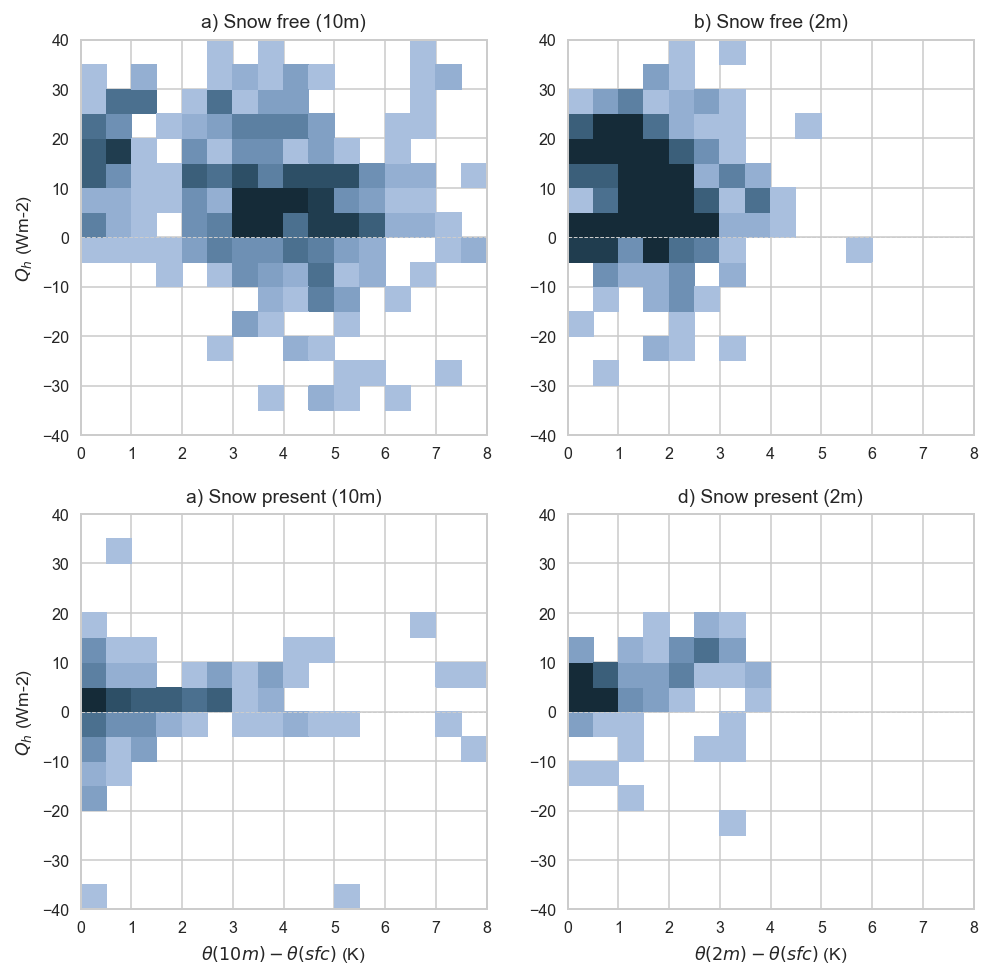

In [29]:
## Plot temperature, RH, and wind by height
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

xmin = 0
xmax = 8
ymin = -40
ymax = 40
dy = 5
dx = .5

# Format figure
## General colorbar arguments
cmin = 0
cmax = 10
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

########
# 10m

# Snow free observations (10m)
ind = (Mtower['RiBulk_10m'] > 0) & sf_ind

ax = axes[0, 0]
X = (Mtower.theta_10m[ind] - Mtower.Tsfc[ind]).values.flatten()
Y = -Mtower.obs_qh_10m[ind].values.flatten()  
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
print(np.nanmean(Y[Y < 0]))
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
# ax.plot(X, Y, '.')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Snow free (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
# ax.text(4, -35, str(np.count_nonzero(support.SensFlux[ind].values.flatten() < 0) / np.count_nonzero(support.SensFlux[ind].values.flatten())))
ax.set_ylabel('$Q_h$ (Wm-2)')

# Snow present
ind = (Mtower['RiBulk_10m'] > 0) & sc_ind

ax = axes[1, 0]
X = (Mtower.theta_10m[ind] - Mtower.Tsfc[ind]).values.flatten()
Y = -Mtower.obs_qh_10m[ind].values.flatten()  
print(np.nanmean(Y[Y < 0]))
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
# ax.plot(X, Y, '.')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('a) Snow present (10m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_xlabel(r'$\theta(10m) - \theta(sfc)$ (K)')
ax.set_ylabel('$Q_h$ (Wm-2)')

########
# 2m

# Snow free observations (2m)
ind = (Mtower['RiBulk_2m'] > 0) & sf_ind

ax = axes[0, 1]
X = (Mtower.theta_2m[ind] - Mtower.Tsfc[ind]).values.flatten()
Y = -Mtower.obs_qh_2m[ind].values.flatten()  
print(np.nanmean(Y[Y < 0]))
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
# ax.plot(X, Y, '.')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('b) Snow free (2m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
# ax.text(4, -35, str(np.count_nonzero(support.SensFlux[ind].values.flatten() < 0) / np.count_nonzero(support.SensFlux[ind].values.flatten())))


# Snow present
ind = (Mtower['RiBulk_2m'] > 0) & sc_ind

ax = axes[1, 1]
X = (Mtower.theta_2m[ind] - Mtower.Tsfc[ind]).values.flatten()
Y = -Mtower.obs_qh_2m[ind].values.flatten()
print(np.nanmean(Y[Y < 0]))
H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax + dx, dx),
                                               np.arange(ymin, ymax + dy, dy)))
H = np.ma.masked_array(H, H < cmin + dcol)
# Plot my 2D histogram
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
# ax.plot(X, Y, '.')

ax.plot([xmin, xmax], [0, 0], '--', color='0.8', linewidth=.5)
ax.set_title('d) Snow present (2m)')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.grid()
ax.set_xlabel(r'$\theta(2m) - \theta(sfc)$ (K)')